In [1]:
"""
Identify wildfire events with >= 1% pre-fire aspen forest cover across western U.S. ecoregions

Data sources
    - Wildfire perimeters: NIFC Interagency Final Wildfire Perimeters
    - Landcover: LANDFIRE Existing Vegetation Type (EVT) ca. 2016
    
Author: maxwell.cook@colorado.edu
"""

import os, sys, time, gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

# maindir = '/home/jovyan/' # cyverse
# projdir = os.path.join(maindir,'data-store/data/iplant/home/maco4303/data/JFSP')

print("Ready to go !")

Ready to go !


In [2]:
results_dir = os.path.join(projdir,'data/tabular/mod/EVT/')
# results_dir = os.path.join(projdir,'results/') # cyverse
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
print(f"Saving EVT summary tables to {results_dir}")

Saving EVT summary tables to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/EVT/


In [3]:
# Join to western U.S. ecoregions

In [4]:
# Load western U.S. ecoregions
fp = os.path.join(projdir,'data/spatial/mod/boundaries/na_cec_eco_l3_west.gpkg')
ecol3 = gpd.read_file(fp)
ecol3 = ecol3[['NA_L3NAME','geometry']]
ecol3 = ecol3.rename(columns={'NA_L3NAME': 'na_l3name'})
ecol3.columns

Index(['na_l3name', 'geometry'], dtype='object')

In [5]:
# Load the NIFC perimeters (2018 to 2023)
fp = os.path.join(projdir,'data/spatial/raw/NIFC/nifc-interagency_2018_to_2023.gpkg')
events = gpd.read_file(fp)
print(f"There are [{len(events)}] NIFC perimeters.\n{events.columns}")

There are [18294] NIFC perimeters.
Index(['OBJECTID', 'MAP_METHOD', 'DATE_CUR', 'COMMENTS', 'GEO_ID', 'IRWINID',
       'UNQE_FIRE_', 'FIRE_YEAR', 'LOCAL_NUM', 'INCIDENT', 'UNIT_ID',
       'POO_RESP_I', 'FEATURE_CA', 'GIS_ACRES', 'USER_NAME', 'SOURCE',
       'AGENCY', 'FIRE_YEAR_', 'Shape__Are', 'Shape__Len', 'FORID', 'OTHERID',
       'geometry'],
      dtype='object')


In [6]:
# Tidy the columns
events = events[['OBJECTID','MAP_METHOD','GEO_ID','IRWINID','FIRE_YEAR',
                 'INCIDENT','FEATURE_CA','GIS_ACRES','geometry']]
events.head()

,OBJECTID,MAP_METHOD,GEO_ID,IRWINID,FIRE_YEAR,INCIDENT,FEATURE_CA,GIS_ACRES,geometry
0,6,Digitized-Other,{FA48870F-92E7-4828-8F17-048DEFEFFE55},{49CC991F-B18D-4DD9-9B4B-864926555272},2018,DEVIL CREEK,Wildfire Final Fire Perimeter,20.46,"MULTIPOLYGON (((-981734.624 1646309.303, -9816..."
1,7,GPS - Differentially Corrected Data,{EDE06BB7-1887-4BED-854B-7574B4F50014},{88801A69-B042-40CA-9011-FAA3C4A12B56},2021,COLT,Wildfire Final Fire Perimeter,30.42,"MULTIPOLYGON (((-1085995.637 1681954.845, -108..."
2,8,Digitized-Other,{F20E18C7-90A3-41DD-99EA-C1F56FA21FEC},{5918038B-F5F3-4C9F-8616-EE1F92817EB5},2019,577,Wildfire Final Fire Perimeter,89.31,"MULTIPOLYGON (((-1003963.720 1628464.675, -100..."
3,12,GPS - Uncorrected Data,{1B76EFA6-D600-45AF-B38B-F1DDD01BB34A},{5169A015-72E1-4FAB-8C9D-C3F70B9E568B},2018,SERVICEBERRY,Wildfire Final Fire Perimeter,41.51,"MULTIPOLYGON (((-956104.449 1624552.505, -9560..."
4,14,Infrared Interpretation,{EBF4910E-B7AB-43E8-ACC2-FB33CE5DB020},{74A8D389-EF55-4C4E-A0A9-49C2495CF697},2018,416,Wildfire Final Fire Perimeter,54130.98,"MULTIPOLYGON (((-1032962.010 1673014.612, -103..."


In [7]:
# Extract within western U.S. ecoregions (CONUS)
centroids = events.copy()
centroids.geometry = centroids.geometry.centroid # use the centroid for joining to ecoregions
assert centroids.crs == ecol3.crs, "CRS mismatch, fix it !"

In [8]:
# identify the ecoregion using overlay
events_west = gpd.overlay(centroids, ecol3, how='intersection') # find overlaps
print(f"There are {len(events_west)} unique fire events across western U.S. ecoregions in CONUS (2018-2023).")
print(f"Data columns:\n{events_west.columns}")

There are 12263 unique fire events across western U.S. ecoregions in CONUS (2018-2023).
Data columns:
Index(['OBJECTID', 'MAP_METHOD', 'GEO_ID', 'IRWINID', 'FIRE_YEAR', 'INCIDENT',
       'FEATURE_CA', 'GIS_ACRES', 'na_l3name', 'geometry'],
      dtype='object')


In [9]:
# Calculate zonal statistics from the LANDFIRE EVT

In [10]:
# Load the LANDFIRE EVT (ca. 2016)
evt_fp = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif')
# evt_fp = os.path.join(dest,'LC16_EVT_200.tif') # cyverse

evt_da = rxr.open_rasterio(evt_fp, masked=True, cache=False, chunks='auto').squeeze()

shp, gt, wkt, nd = evt_da.shape, evt_da.spatial_ref.GeoTransform, evt_da.rio.crs, evt_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {evt_da[0].dtype}")
gc.collect()

Shape: (97283, 154207); 
GeoTransform: -2362425.0 30.0 0.0 3177435.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


70

In [11]:
# Add a small buffer to wildfire perimeters
buffer_dist = 90  # meters
events_west_ = events_west.copy() # make a copy of the original data
events_west_['geometry'] = events_west_['geometry'].buffer(buffer_dist)
print(f"Buffered fire perimeters by {buffer_dist} meters.")

Buffered fire perimeters by 90 meters.


In [12]:
# Crop the raster by the fire bounds (with small buffer)
bounds = events_west_.total_bounds
evt_da_crop = evt_da.rio.clip_box(
    minx=bounds[0]+1000, 
    miny=bounds[1]+1000, 
    maxx=bounds[2]+1000, 
    maxy=bounds[3]+1000
)
del evt_da, bounds
gc.collect()

66

In [13]:
# Calculate zonal stats for the wildfire perimeters

In [14]:
t0 = time.time()

sampled = compute_band_stats(events_west_, evt_da_crop, 'OBJECTID')

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

Total elapsed time: 1.13 minutes.

~~~~~~~~~~



In [15]:
sampled.head()

,OBJECTID,evt,count,total_pixels,pct_cover
0,6,7011,14.0,40.0,35.0
1,6,7051,3.0,40.0,7.5
2,6,7054,22.0,40.0,55.0
3,6,7061,1.0,40.0,2.5
4,7,7054,41.0,41.0,100.0


In [17]:
del evt_da_crop
gc.collect()  # clean up

In [ ]:
# Load the lookup table and gather LC info

In [18]:
lookup_fp = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv')
lookup = pd.read_csv(lookup_fp)
lookup.columns

Index(['VALUE', 'EVT_NAME', 'LFRDB', 'EVT_FUEL', 'EVT_FUEL_N', 'EVT_LF',
       'EVT_PHYS', 'EVT_GP', 'EVT_GP_N', 'SAF_SRM', 'EVT_ORDER', 'EVT_CLASS',
       'EVT_SBCLS', 'R', 'G', 'B', 'RED', 'GREEN', 'BLUE'],
      dtype='object')

In [19]:
# Subset the codes we want to join, join back to the dataframe
lookup = lookup[['VALUE','EVT_NAME','EVT_PHYS','EVT_GP_N','EVT_CLASS']]
props_df = sampled.merge(lookup, left_on='evt', right_on='VALUE', how='left')
props_df.head()

,OBJECTID,evt,count,total_pixels,pct_cover,VALUE,EVT_NAME,EVT_PHYS,EVT_GP_N,EVT_CLASS
0,6,7011,14.0,40.0,35.0,7011,Rocky Mountain Aspen Forest and Woodland,Hardwood,"Aspen Forest, Woodland, and Parkland",Open tree canopy
1,6,7051,3.0,40.0,7.5,7051,Southern Rocky Mountain Dry-Mesic Montane Mixe...,Conifer,Douglas-fir-Ponderosa Pine-Lodgepole Pine Fore...,Closed tree canopy
2,6,7054,22.0,40.0,55.0,7054,Southern Rocky Mountain Ponderosa Pine Woodland,Conifer,"Ponderosa Pine Forest, Woodland and Savanna",Open tree canopy
3,6,7061,1.0,40.0,2.5,7061,Inter-Mountain Basins Aspen-Mixed Conifer Fore...,Conifer-Hardwood,Aspen-Mixed Conifer Forest and Woodland,Open tree canopy
4,7,7054,41.0,41.0,100.0,7054,Southern Rocky Mountain Ponderosa Pine Woodland,Conifer,"Ponderosa Pine Forest, Woodland and Savanna",Open tree canopy


In [22]:
print(f"There are [{len(props_df['OBJECTID'].unique())}] unique fires in the sampled data.")

There are [12261] unique fires in the sampled data.


In [23]:
# Save the file out.
out_fp = os.path.join(results_dir, 'nifc-interagency_2018_to_2023-EVT.csv')
props_df.to_csv(out_fp)
print(f"Saved to {out_fp}")

Saved to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/EVT/nifc-interagency_2018_to_2023-EVT.csv


In [ ]:
# Identify fires with >= 1% aspen forest cover

In [29]:
aspen_evt_classes = props_df[props_df['EVT_NAME'].str.contains('aspen', case=False, na=False)]['EVT_NAME'].unique()
print(f"LANDFIRE EVT Aspen Classes:\n\n{aspen_evt_classes}")

LANDFIRE EVT Aspen Classes:

['Rocky Mountain Aspen Forest and Woodland'
 'Inter-Mountain Basins Aspen-Mixed Conifer Forest and Woodland'
 'Northwestern Great Plains Aspen Forest and Parkland']


In [31]:
# Isolate the aspen EVT classes, calculate the "aspen percent"
df = props_df[props_df['EVT_NAME'].isin(aspen_evt_classes)] # grab aspen EVT classes
aspen_sum = df.groupby('OBJECTID')['pct_cover'].sum().reset_index() # get the sum of pct_cover
aspen_sum['pct_aspen'] = aspen_sum['pct_cover']  # rename the column to retain aspen percent

del df # clean up
gc.collect()

1673

In [32]:
# Now filter fires where "pct_aspen" >= 1%
aspen_events = aspen_sum[aspen_sum['pct_aspen'] >= 1] # retain fires with >= X %
aspen_events = aspen_events[['OBJECTID','pct_aspen']] # subset columns
print(f"There are [{len(aspen_events)}] fire events with > 1% aspen cover across western U.S. ecoregions (2018-2023).")

There are [327] fire events with > 1% aspen cover across western U.S. ecoregions (2018-2023).


In [34]:
# Join aspen percent to the spatial data.
props_gdf = pd.merge(events_west_, aspen_events, on='OBJECTID', how='inner')
props_gdf = props_gdf.to_crs(proj)  # ensure the correct projection before exporting
props_gdf.columns

Index(['OBJECTID', 'MAP_METHOD', 'GEO_ID', 'IRWINID', 'FIRE_YEAR', 'INCIDENT',
       'FEATURE_CA', 'GIS_ACRES', 'na_l3name', 'geometry', 'pct_aspen'],
      dtype='object')

In [35]:
# Save this file out
out_fp = os.path.join(projdir,'data/spatial/mod/nifc-interagency_2018_to_2023-EVT-aspen.gpkg')
props_gdf.to_file(out_fp)
print(f"Saved file to {out_fp}")

Saved file to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/nifc-interagency_2018_to_2023-EVT-aspen.gpkg


In [ ]:
# Map

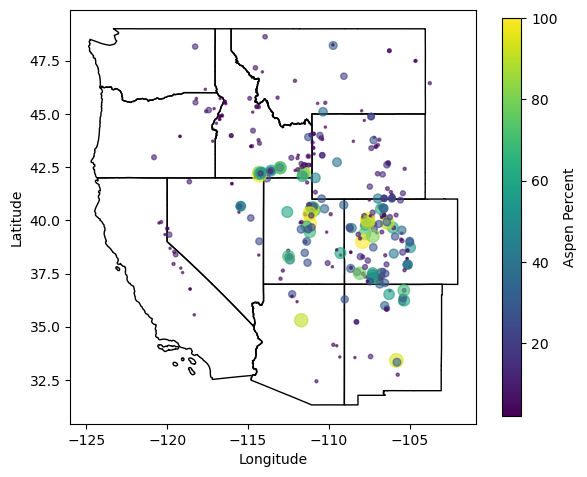

In [36]:
# Load the state boundaries
states = gpd.read_file(os.path.join(maindir,'data/boundaries/political/TIGER/tl19_us_states_west_nad83.gpkg'))
states = states.to_crs(4326)

# Generate centroids
centroid = props_gdf.copy()
centroid = centroid.to_crs(4326)
centroid['geometry'] = centroid.geometry.centroid
centroid['size'] = centroid['pct_aspen'] * 10  # Adjust the scaling factor as necessary

# Make a spatial map of the centroids now
fig, ax = plt.subplots(figsize=(6, 6))

states.plot(ax=ax, edgecolor='black', linewidth=1, color='none')
centroid.plot(
    ax=ax, markersize=centroid['pct_aspen'], 
    column='pct_aspen', cmap='viridis', 
    legend=False, alpha=0.6)

# Manually add colorbar
norm = matplotlib.colors.Normalize(vmin=centroid['pct_aspen'].min(), vmax=centroid['pct_aspen'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Only needed for ScalarMappable

# Adjust the size of the colorbar using the `shrink` parameter
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Aspen Percent')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# Save the map as a PNG
plt.savefig(os.path.join(projdir, 'figures/Fig1_all_aspen_fires-NIFC.png'), dpi=300, bbox_inches='tight')

plt.show()